In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Sensitivity Analysis

In [2]:
from model import SteadyStateMotor as Motor

Motor.build({})

<NonlinearIOSystem motor: ['motor_v', 'motor_q_load'] -> ['motor_i', 'motor_w']>

In [3]:
motor_params = {
    'motor_R_A': 0.1,
    'motor_B': 0.1,
    'motor_K_Q': 0.1,
    'motor_K_V': 0.1,
}

In [4]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Motor.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

def motor_sensitivity_analysis_step_response(
    params_description: dict,
    voltage_step: float,
    motor_load_torque_step: float,
    samples: int,
    do_plot=True,
):

    model_class = Motor
    model_params = motor_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 10, 11, endpoint=True)

    # Initial state
    X0 = np.zeros(model_tmp.nstates)

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('motor_v')] = voltage_step
    U[model_tmp.input_labels.index('motor_q_load')] = motor_load_torque_step

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=True,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=8, t_end=10)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}.tex",
        label=f'table:motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}',
        caption='Índices de Sobol em regime permanente',
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        # fig_save_and_show(
        #     None,
        #     'Distribuição dos valores para cada fator',
        #     'Distribution of the values for each factor',
        #     fig=plot_sampled_distribuitions(problem),
        #     ncols=3,
        # )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples',
        #         fig=plot_sensitivity_analysis(df_sa, output=output),
        #         ncols=3,
        #     )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples',
        #         fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
        #         ncols=3,
        #     )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                f'{latex_img_path}/motor_sensitivity_analysis_{output}_{voltage_step}_{motor_load_torque_step}.pdf',
                f'Índices de Sobol para a saída {output} em regime permanente',
                f'Sobol Indices for the output {output} at steady-state with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples',
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem

In [5]:
# Setting all uncertainties to be 10%
u_motor_R_A = 1/100
u_motor_B = 1/100
u_motor_K_Q = 1/100
u_motor_K_V = 1/100

pool
chain


value      conf
output  factor                 metric                        
motor_i motor_R_A              S1      3.789389e-01  0.006918
                               ST      3.789670e-01  0.004129
        motor_K_V              S1      1.210536e-01  0.003595
                               ST      1.210619e-01  0.001474
        motor_K_Q              S1      3.789246e-01  0.006553
                               ST      3.789385e-01  0.004206
        motor_B                S1      1.210536e-01  0.003722
                               ST      1.210619e-01  0.001331
        (motor_R_A, motor_K_V) S2      7.736140e-06  0.009137
        (motor_R_A, motor_K_Q) S2      1.263182e-05  0.011124
        (motor_R_A, motor_B)   S2      7.735043e-06  0.009645
        (motor_K_Q, motor_K_V) S2      5.984393e-07  0.009007
        (motor_B, motor_K_V)   S2      2.372218e-10  0.005622
        (motor_B, motor_K_Q)   S2      5.973328e-07  0.005855
motor_w motor_R_A              S1      3.789289e-01  0.005708
                               ST      3.789373e-01  0.003571
        motor_K_V              S1      1.210679e-01  0.003334
                               ST      1.210874e-01  0.001339
        motor_K_Q              S1      3.789289e-01  0.005936
                               ST      3.789373e-01  0.004460
        motor_B                S1      1.210536e-01  0.004029
                               ST      1.210588e-01  0.001311
        (motor_R_A, motor_K_V) S2      7.737412e-06  0.008840
        (motor_R_A, motor_K_Q) S2      7.552044e-10  0.009389
        (motor_R_A, motor_B)   S2      5.939218e-07  0.008825
        (motor_K_Q, motor_K_V) S2      7.740633e-06  0.008186
        (motor_B, motor_K_V)   S2      4.033097e-06  0.006068
        (motor_B, motor_K_Q)   S2      5.968509e-07  0.006462

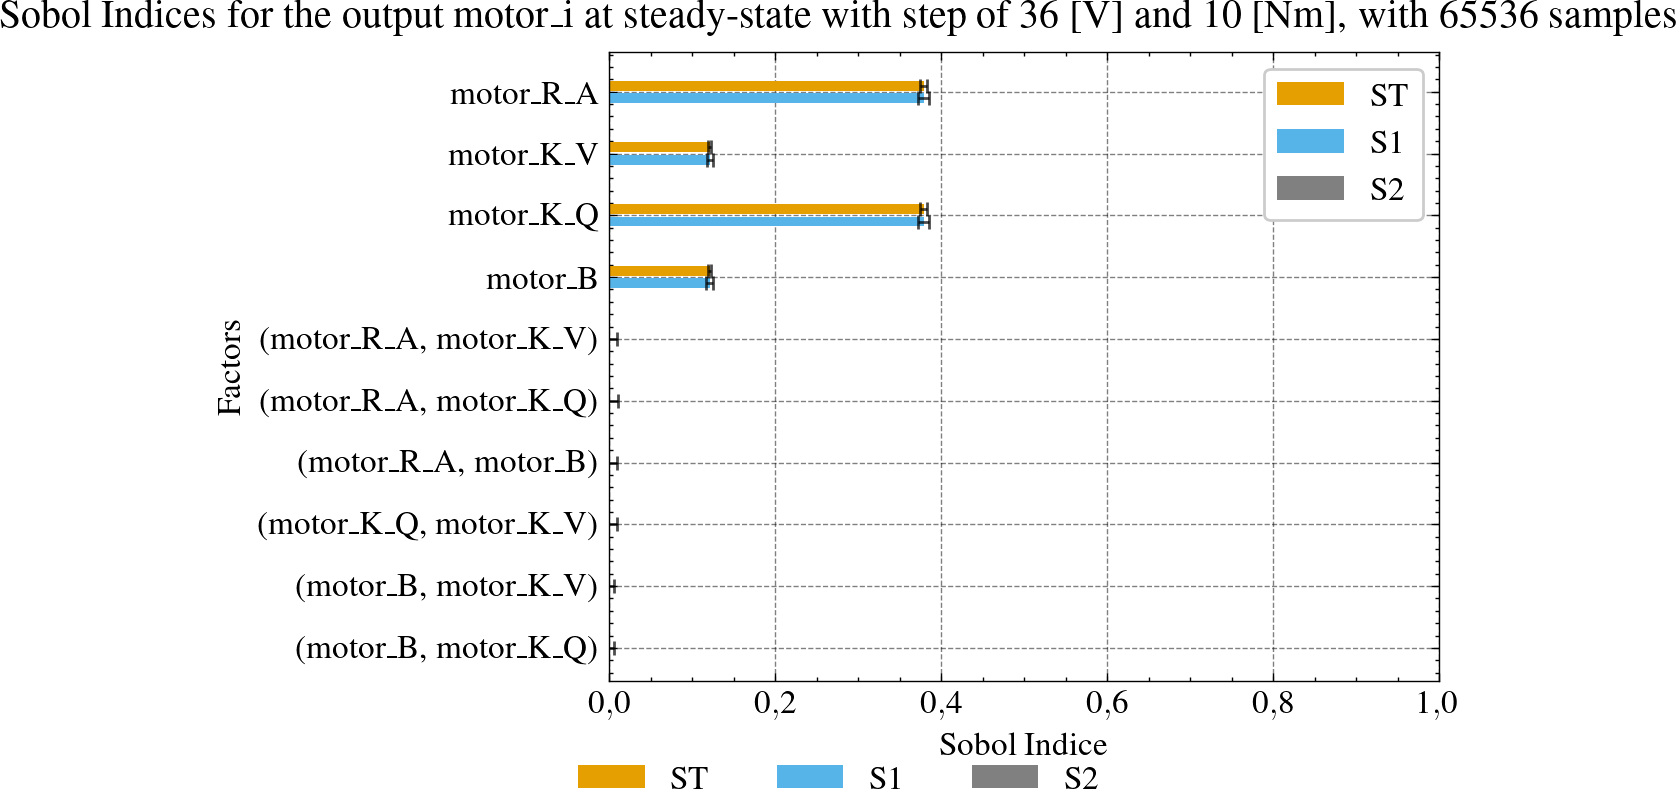

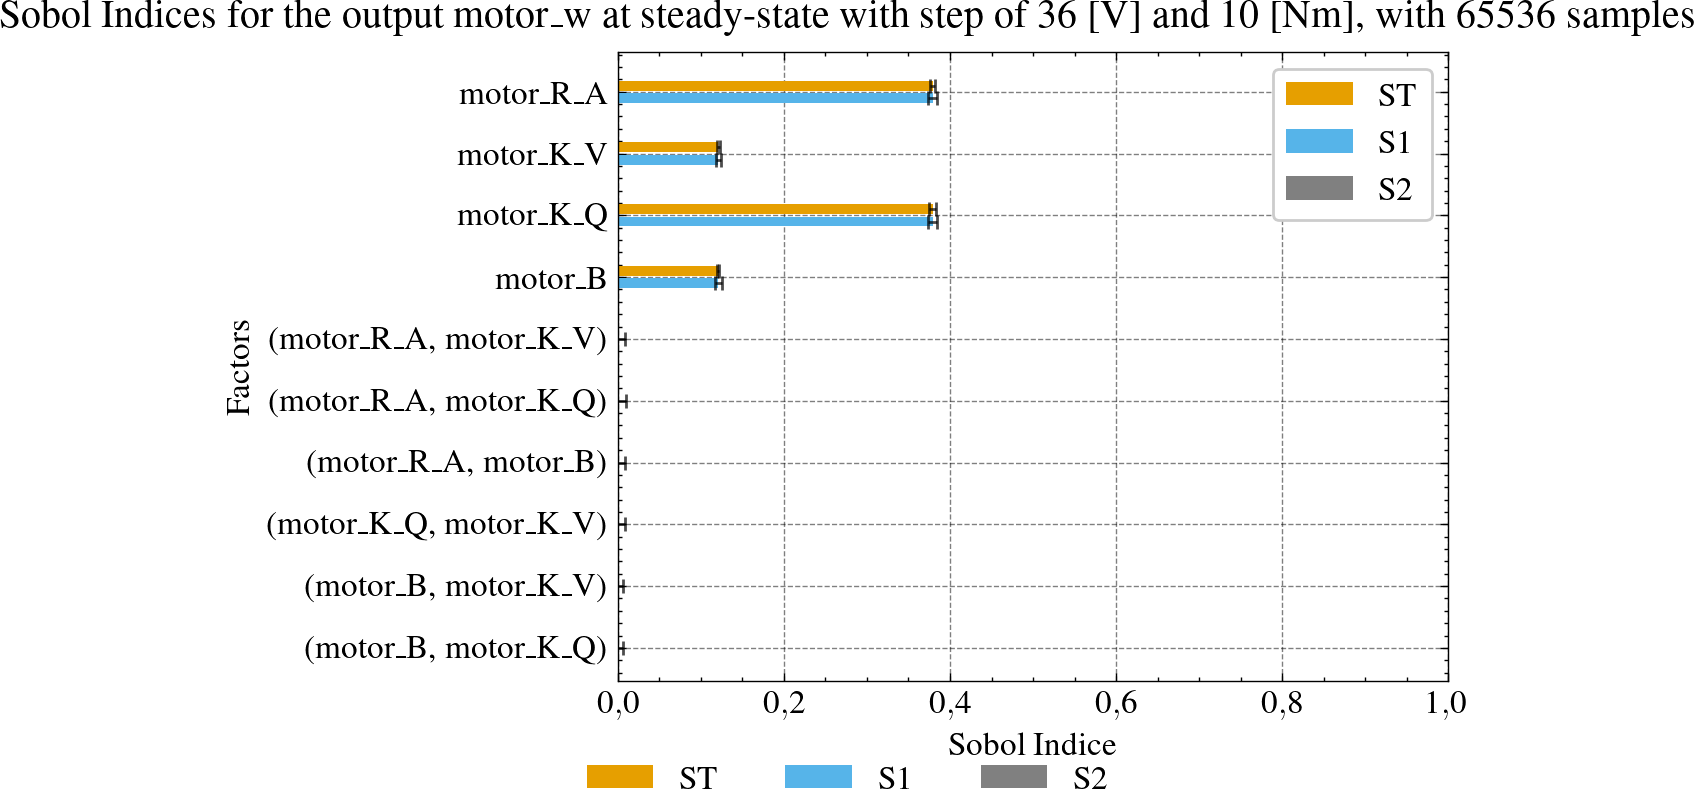

CPU times: user 2.28 s, sys: 3.41 s, total: 5.69 s
Wall time: 38.6 s


In [6]:
%%time

params_description = {
    'motor_R_A': describe_param_with_uniform_distribution(lower=motor_params['motor_R_A']*(1-u_motor_R_A), upper=motor_params['motor_R_A']*(1+u_motor_R_A)),
    'motor_B': describe_param_with_uniform_distribution(lower=motor_params['motor_B']*(1-u_motor_B), upper=motor_params['motor_B']*(1+u_motor_B)),
    'motor_K_Q': describe_param_with_uniform_distribution(lower=motor_params['motor_K_Q']*(1-u_motor_K_Q), upper=motor_params['motor_K_Q']*(1+u_motor_K_Q)),
    'motor_K_V': describe_param_with_uniform_distribution(lower=motor_params['motor_K_V']*(1-u_motor_K_V), upper=motor_params['motor_K_V']*(1+u_motor_K_V)),
}

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=10,
    samples=2**16,
    do_plot=True,
)

pool
chain


value      conf
output  factor                 metric                        
motor_i motor_R_A              S1      2.500062e-01  0.005481
                               ST      2.500313e-01  0.002788
        motor_K_V              S1      2.499896e-01  0.004716
                               ST      2.499979e-01  0.003009
        motor_K_Q              S1      2.499896e-01  0.005412
                               ST      2.499979e-01  0.002957
        motor_B                S1      2.499896e-01  0.005183
                               ST      2.499979e-01  0.002770
        (motor_R_A, motor_K_V) S2      8.333499e-06  0.008167
        (motor_R_A, motor_K_Q) S2      8.333784e-06  0.008844
        (motor_R_A, motor_B)   S2      8.333302e-06  0.008792
        (motor_K_Q, motor_K_V) S2      2.997727e-10  0.007942
        (motor_B, motor_K_V)   S2      1.525797e-09  0.008443
        (motor_B, motor_K_Q)   S2      1.012559e-09  0.007895
motor_w motor_R_A              S1      2.499896e-01  0.004713
                               ST      2.499979e-01  0.002352
        motor_K_V              S1      2.500062e-01  0.004677
                               ST      2.500313e-01  0.002640
        motor_K_Q              S1      2.499896e-01  0.004954
                               ST      2.499979e-01  0.002975
        motor_B                S1      2.499896e-01  0.005874
                               ST      2.499979e-01  0.002607
        (motor_R_A, motor_K_V) S2      8.334246e-06  0.007714
        (motor_R_A, motor_K_Q) S2      7.553112e-10  0.007397
        (motor_R_A, motor_B)   S2     -2.077325e-09  0.007949
        (motor_K_Q, motor_K_V) S2      8.336568e-06  0.007450
        (motor_B, motor_K_V)   S2      8.330578e-06  0.009197
        (motor_B, motor_K_Q)   S2      4.831624e-11  0.008807

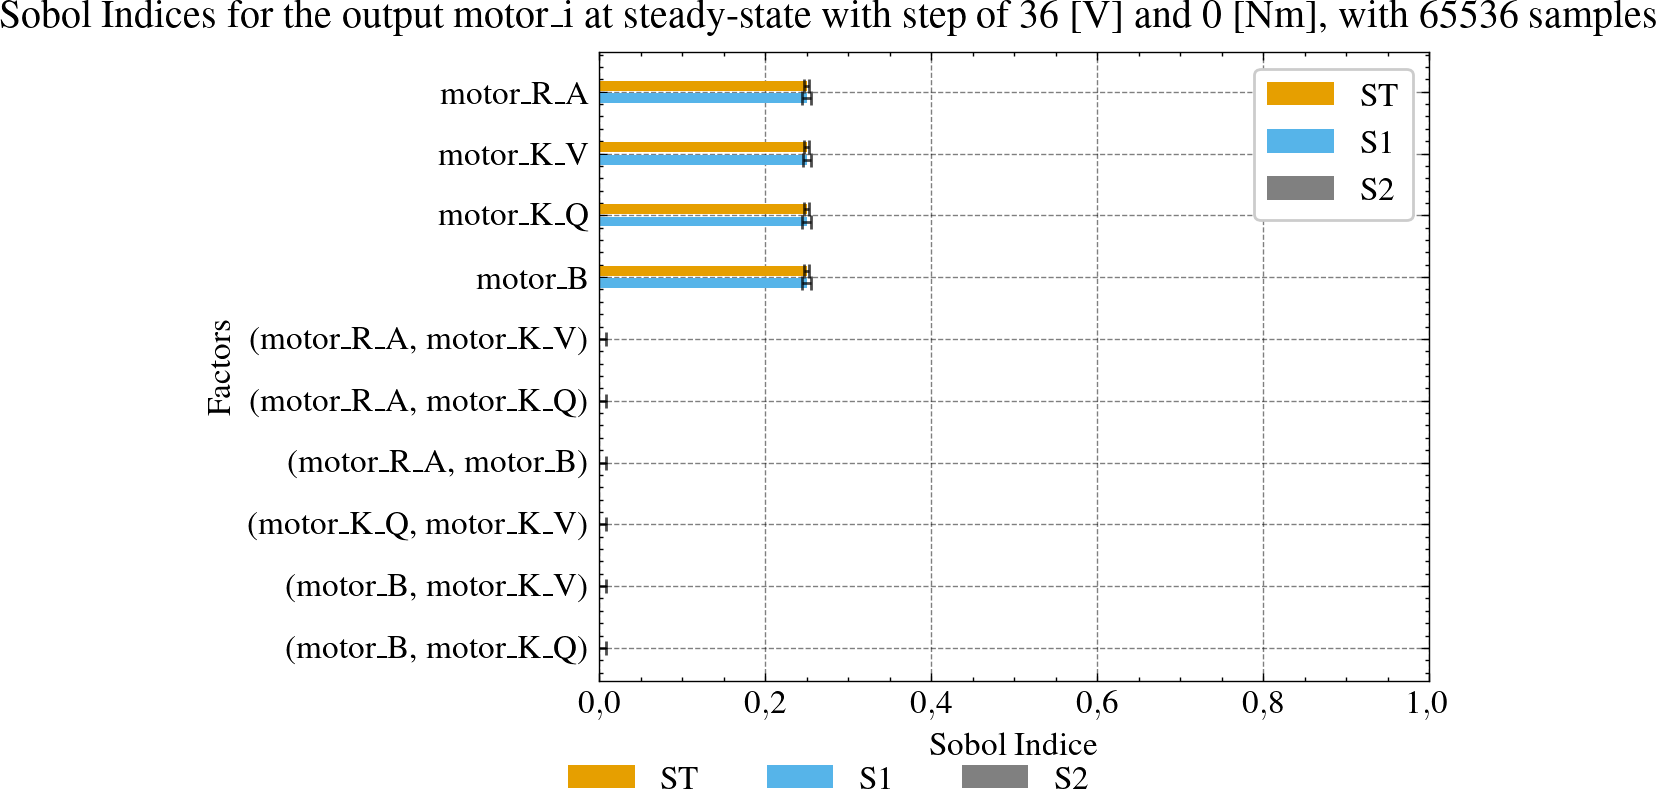

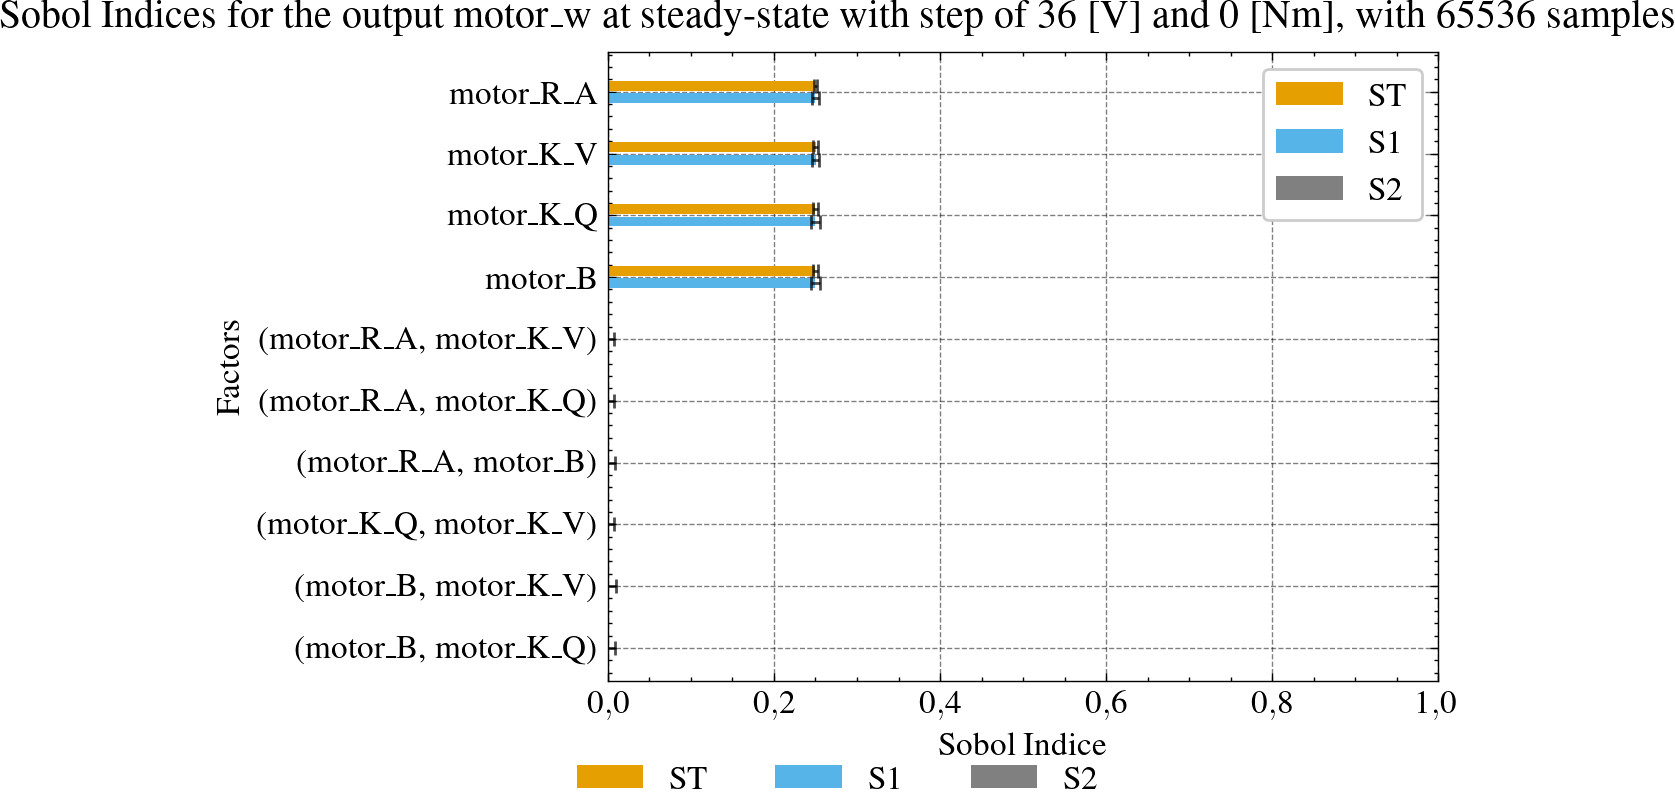

In [7]:
df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=0,
    samples=2**16,
    do_plot=True,
)